### Libraries

In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile
from io import BytesIO
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
from pytorch_msssim import ssim

### DataLoader

In [2]:
train_higher_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_train_HR.zip'
train_lower_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_train_LR_bicubic_X4.zip'

valid_higher_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_valid_HR.zip'
valid_lower_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_valid_LR_bicubic_X4.zip'

In [3]:
def get_transform():
    return Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [4]:
class ZipDataset(Dataset):
    def __init__(self, zip_file_HR, zip_file_LR, transform=None):
        self.zip_file_HR = ZipFile(zip_file_HR)
        self.zip_file_LR = ZipFile(zip_file_LR)
        self.file_list_HR = self.zip_file_HR.namelist()
        self.file_list_HR = [file for file in self.file_list_HR if file.endswith(('.png', '.jpg', '.jpeg'))]
        self.file_list_LR = self.zip_file_LR.namelist()
        self.file_list_LR = [file for file in self.file_list_LR if file.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = get_transform()

        self.lr_mapping = {os.path.splitext(os.path.basename(name))[0].split('x')[0]: i for i, name in enumerate(self.file_list_LR)}

    def __len__(self):
        return len(self.file_list_HR)

    def __getitem__(self, idx):
        file_HR = self.file_list_HR[idx]
        # Get the base name of the HR image
        base_name_HR = os.path.splitext(os.path.basename(file_HR))[0]
        # Find the corresponding LR image
        idx_LR = self.lr_mapping[base_name_HR]
        file_LR = self.file_list_LR[idx_LR]
        
        # printing to check the image names are same or not
        
        # print(file_HR)
        # print(file_LR)

        with self.zip_file_HR.open(file_HR) as f:
            image_HR = Image.open(BytesIO(f.read()))
        with self.zip_file_LR.open(file_LR) as f:
            image_LR = Image.open(BytesIO(f.read()))
        if self.transform:
            image_HR = self.transform(image_HR)
            image_LR = self.transform(image_LR)

        return image_LR, image_HR

#### Creating datasets

In [5]:
train_dataset = ZipDataset(train_higher_images, train_lower_images)
valid_dataset = ZipDataset(valid_higher_images, valid_lower_images)

#### Creating datasets

In [6]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return [data, target]

In [7]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=my_collate)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=my_collate)

#### Testing with images

In [8]:
# iterate over the dataloader
for i, (images, labels) in enumerate(train_loader):
    # print the shapes of the images and labels
    print(f'Batch {i+1}:')
    print('Images shape:', images[0].shape)
    print('Labels shape:', labels[0].shape)
    # break the loop after the first batch
    break

Batch 1:
Images shape: torch.Size([3, 306, 510])
Labels shape: torch.Size([3, 1224, 2040])


In [9]:
def tensor_to_image(tensor):
    # Select the first image from the batch
    # 
    tensor = tensor.cuda()

    # Define the mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Unnormalize the tensor
    std = std.cuda()
    mean = mean.cuda()
    tensor = tensor * std + mean

    # Clamp the values in the tensor to the range [0, 1]
    tensor = torch.clamp(tensor, 0, 1)

    # Convert the tensor to a PIL Image and then convert it to a numpy array
    image = transforms.ToPILImage()(tensor).convert("RGB")
    plt.imshow(image)
    plt.show()

In [10]:
i = 1

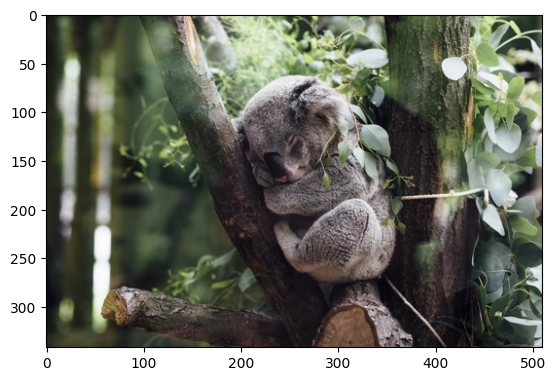

In [11]:
tensor_to_image(images[i])

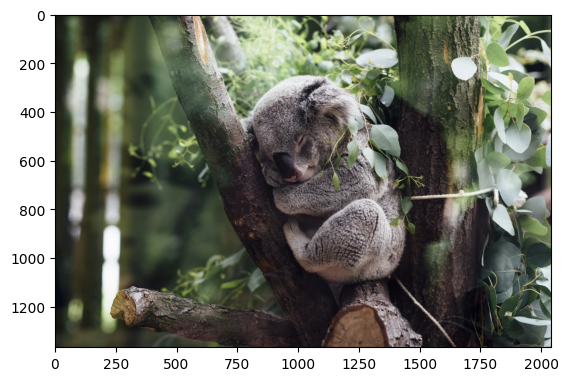

In [12]:
tensor_to_image(labels[i])

### Model with modules

#### RCAT module

In [13]:
class RCat(nn.Module):
    def __init__(self, f):
        super(RCat, self).__init__()
        self.conv1 = nn.Conv2d(f, f//4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(f, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2)
        self.conv5 = nn.Conv2d(16, 16, kernel_size=7, stride=1, padding=3)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(f//2, f//4, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x))
        x1 = F.relu(self.conv3(x1))
        x1 = F.relu(self.conv4(x1))
        x1 = F.relu(self.conv5(x1))
        x1 = F.relu(self.conv6(x1))
        c1 = torch.cat((x1, y1), dim=1)
        c2 = F.relu(self.conv7(c1))
        return c2 + y1

#### RDN module

In [14]:
class RDN(nn.Module):
    def __init__(self, f):
        super(RDN, self).__init__()
        self.conv1 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(3*f, f//4, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        y1 = self.conv1(x)
        y2 = self.conv2(y1)
        a1 = y1 + y2
        y3 = self.conv3(a1)
        a2 = y3 + a1
        y4 = self.conv4(a2)
        a3 = a1 + a2 + y4
        c = torch.cat((a1, a2, a3), dim=1)
        return self.conv5(c)

#### RUNT module

In [15]:
class Runt(nn.Module):
    def __init__(self, f):
        super(Runt, self).__init__()
        self.conv1 = nn.Conv2d(f, f, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(f, f, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(f, f//2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(f//2, f//2, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(f//2, f//4, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(f//4, f//4, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(f//4, f//8, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(f//8, f//8, kernel_size=5, padding=2)
        self.conv9 = nn.Conv2d(f//8, f//8, kernel_size=1)
        self.conv10 = nn.Conv2d(f//4, f//4, kernel_size=1)
        self.conv11 = nn.Conv2d(f//2, f//2, kernel_size=1)
        self.conv12 = nn.Conv2d(f, f, kernel_size=1)
        self.conv13 = nn.Conv2d(f, 3, kernel_size=1)

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        y1 = F.relu(self.conv2(y1))
        y2 = F.relu(self.conv3(y1))
        y2 = F.relu(self.conv4(y2))
        y3 = F.relu(self.conv5(y2))
        y3 = F.relu(self.conv6(y3))
        y4 = F.relu(self.conv7(y3))
        y4 = F.relu(self.conv8(y4))
        y5 = F.relu(self.conv9(y4))
        c1 = torch.cat([y5, y4], dim=1)
        y6 = F.relu(self.conv10(c1))
        c2 = torch.cat([y6, y3], dim=1)
        y7 = F.relu(self.conv11(c2))
        c3 = torch.cat([y7, y2], dim=1)
        y8 = F.relu(self.conv12(c3))
        y8 = y8 + y1
        y9 = self.conv13(y8)
        return y9

#### DEN module

In [16]:
class Den(nn.Module):
    def __init__(self):
        super(Den, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=1)
        self.actc = ACTC()  # Assuming ACTC is a defined PyTorch module
        self.mdr_inp = nn.Conv2d(64, 3, kernel_size=1) 
        self.mdsr1 = MDSR1(32)  # Assuming MDSR1 is a defined PyTorch module
        self.rdn_inp = nn.Conv2d(64, 128, kernel_size=1) 
        self.rdn = RDN(128)  # Assuming RDN is a defined PyTorch module
        self.conv4 = nn.Conv2d(102, 3, kernel_size=3, padding=2, dilation=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        f1 = self.actc(x)
        md_in = self.mdr_inp(x)
        f2 = self.mdsr1(md_in)
        rd_in = self.rdn_inp(x)
        f3 = self.rdn(rd_in)
        inp = torch.cat([f1, f2, f3, x], dim=1)
        x = self.conv4(inp)
        return x

#### ACTC module

In [17]:
class ACTC(nn.Module):
    def __init__(self):
        super(ACTC, self).__init__()
        self.conv1 = nn.Conv2d(64, 7, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 7, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 7, kernel_size=7, padding=3)
        self.conv4 = nn.Conv2d(21, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = F.relu(x)
        x2 = torch.sigmoid(x)
        x3 = x2 * x
        x4 = F.softplus(x)
        x4 = torch.tanh(x4)
        x5 = x4 * x
        c1 = self.conv1(x1)
        c2 = self.conv2(x3)
        c3 = self.conv3(x5)
        cx = torch.cat([c1, c2, c3], dim=1)
        y = self.conv4(cx)
        return y

#### R1 module

In [18]:
class R1(nn.Module):
    def __init__(self, features):
        super(R1, self).__init__()
        self.conv1 = nn.Conv2d(features, features, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(features, features, kernel_size=3, padding=1)

    def forward(self, input_tensor):
        x = F.relu(self.conv1(input_tensor))
        x = self.conv2(x)
        return x + input_tensor

#### MDSR1 module

In [19]:
class MDSR1(nn.Module):
    def __init__(self, f):
        super(MDSR1, self).__init__()
        self.conv1 = nn.Conv2d(3, f, kernel_size=3, padding=1)
        self.r1 = R1(f)  # Assuming R1 is a defined PyTorch module
        self.conv2 = nn.Conv2d(4*f, 3, kernel_size=3, padding=1)

    def forward(self, ix):
        x = F.relu(self.conv1(ix))
        x1 = self.r1(x)
        x1 = self.r1(x1)
        x2 = self.r1(x)
        x2 = self.r1(x2)
        x3 = self.r1(x)
        x3 = self.r1(x3)
        x = x1 + x2 + x3
        x = torch.cat([x, x1, x2, x3], dim=1)
        x = self.conv2(x)
        return x

#### Created Custom Model

In [20]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=0, dilation=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0, dilation=4)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=1, padding=0, dilation=16)
        self.den_inp = nn.Conv2d(64, 3, kernel_size=1) 
        self.den = Den()  # Assuming Den is a defined PyTorch module
        self.runt_inp = nn.Conv2d(64, 16, kernel_size=1) 
        self.runt = Runt(16)  # Assuming Runt is a defined PyTorch module
        self.conv4 = nn.Conv2d(6, 3, kernel_size=1, padding=1, dilation=8)  # Adjusted number of input channels
        self.runt_inp2 = nn.Conv2d(3, 32, kernel_size=1)
        self.runt2 = Runt(32)  # Assuming Runt is a defined PyTorch module
        self.conv5 = nn.Conv2d(6, 3, kernel_size=1, padding=1, dilation=8)  # Adjusted number of input channels

    def forward(self, input_im):
        x = F.relu(self.conv1(input_im))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        den_in = self.den_inp(x) 
        x1 = self.den(den_in)
        runt_in = self.runt_inp(x)
        x2 = self.runt(runt_in)
        x = torch.cat([x1, x2], dim=1)
        # print(x.shape)
        x = F.relu(self.conv4(x))
        x1 = self.den(x)
        runt_in = self.runt_inp2(x)
        x2 = self.runt2(runt_in)
        x = torch.cat([x1, x2], dim=1)
        y = self.conv5(x)
        # Upsample the output to be 4 times the size of the input
        y = F.interpolate(y, scale_factor=4, mode='bicubic', align_corners=False)
        return y

### Training part

#### Custom Losses

##### Smoothing Loss

In [21]:
class SmoothingLoss(nn.Module):
    def __init__(self):
        super(SmoothingLoss, self).__init__()

    def forward(self, prediction, target):
        # Apply smoothing to the target
        target_smooth = self.smooth_target(target)

        # Compute the absolute difference between the prediction and the smoothed target
        diff = torch.abs(target_smooth - prediction)

        # Compute the loss as the mean of the absolute differences
        loss = torch.mean(diff)
        return loss

    def smooth_target(self, target):
        # Apply Gaussian filter
        gaussian_filter = torch.tensor([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]]) / 16.0
        gaussian_filter = gaussian_filter.repeat(target.shape[1], 1, 1, 1).to(target.device)
        target_smooth = F.conv2d(target, gaussian_filter, padding=1, groups=target.shape[1])

        # Apply consecutive upsampling and downsampling
        target_smooth = F.interpolate(target_smooth, scale_factor=2, mode='bilinear', align_corners=False)
        target_smooth = F.interpolate(target_smooth, scale_factor=0.5, mode='bilinear', align_corners=False)

        return target_smooth

##### SSIM Loss

In [22]:
def calculate_ssim(y_true, y_pred, data_range):
    # Calculate SSIM
    ssim_val = ssim(y_true, y_pred, data_range=data_range, size_average=True)
    
    # Return SSIM value
    return ssim_val

#### Parameter Setting

In [23]:
# Instantiate the model
model = MyModel()

# Define a loss function
mse_criterion = nn.MSELoss()
smoothing_criterion = SmoothingLoss()

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

num_epochs = 50

if torch.cuda.is_available():
    device = torch.device('cuda')  # Default CUDA device
    num_gpus = torch.cuda.device_count()
    print(f'{num_gpus} GPUs available')

    model = nn.DataParallel(model)  # Use multiple GPUs
    model.to(device)
else:
    print('CUDA is not available.')

1 GPUs available


#### Training loop

In [24]:
min_val_loss = float('inf')
best_model_path = None

#####  Only run the following cell if there is a weight avilable

In [24]:
# weights_path = './weights/model_epoch_7_val_loss_0.06323117017745972.pth' 
weights_path = './weights/model_sms_epoch_50_val_loss_0.54889.pth' 

# Load the weights into the model
model.load_state_dict(torch.load(weights_path))

# if torch.cuda.is_available():
#     model = model.cuda()

<All keys matched successfully>

In [26]:
for epoch in range(num_epochs):
    # Training phase
    model.train()  
    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
        for input1, target in zip(inputs, targets):
            if torch.cuda.is_available():
                input1 = input1.to(device)
                target = target.to(device)

            output = model(input1.unsqueeze(0))

            # Compute the smoothing loss
            smoothing_loss = smoothing_criterion(output, target.unsqueeze(0))

            # Compute the mean squared error loss
            mse_loss = mse_criterion(output, target.unsqueeze(0))

            # SSIM loss
            ssim_loss = 1 - calculate_ssim(output, target.unsqueeze(0), 1.0)

            # Combine the losses
            loss = smoothing_loss + mse_loss + ssim_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print(f'Training Loss: {loss.item()}')
    
    # Validation phase
    model.eval()  
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(valid_loader):
            for input1, target in zip(inputs, targets):
                if torch.cuda.is_available():
                    input1 = input1.to(device)
                    target = target.to(device)

                output = model(input1.unsqueeze(0))

                # Compute the validation loss
                val_loss = smoothing_criterion(output, target.unsqueeze(0)) + mse_criterion(output, target.unsqueeze(0)) + (1 - calculate_ssim(output, target.unsqueeze(0), 1.0))

    print(f'Validation Loss: {val_loss.item()}')
    
    scheduler.step(val_loss.item())
    
    if val_loss.item() < min_val_loss:
        min_val_loss = val_loss.item()

        if not os.path.exists('./weights'):
            os.makedirs('./weights')
        
        if best_model_path is not None:
            os.remove(best_model_path)
        
        # Save the new best model and update the best model path
        best_model_path = f'./weights/model_sms_epoch_{epoch+1}_val_loss_{val_loss.item():.5f}.pth'
        torch.save(model.state_dict(), best_model_path)

Training Epoch 1/50: 100%|██████████| 200/200 [09:07<00:00,  2.74s/it]


Training Loss: 0.5406962037086487
Validation Loss: 0.5811356902122498


Training Epoch 2/50: 100%|██████████| 200/200 [09:27<00:00,  2.84s/it]


Training Loss: 0.4802444875240326
Validation Loss: 0.5771784782409668


Training Epoch 3/50: 100%|██████████| 200/200 [09:25<00:00,  2.83s/it]


Training Loss: 0.5110310912132263
Validation Loss: 0.5809115171432495


Training Epoch 4/50: 100%|██████████| 200/200 [09:16<00:00,  2.78s/it]


Training Loss: 0.7008578181266785
Validation Loss: 0.5715201497077942


Training Epoch 5/50: 100%|██████████| 200/200 [09:19<00:00,  2.80s/it]


Training Loss: 0.6696857213973999
Validation Loss: 0.5748622417449951


Training Epoch 6/50: 100%|██████████| 200/200 [09:18<00:00,  2.79s/it]


Training Loss: 0.5038625597953796
Validation Loss: 0.5685882568359375


Training Epoch 7/50: 100%|██████████| 200/200 [09:14<00:00,  2.77s/it]


Training Loss: 0.41222792863845825
Validation Loss: 0.5732671022415161


Training Epoch 8/50: 100%|██████████| 200/200 [09:14<00:00,  2.77s/it]


Training Loss: 0.42298492789268494
Validation Loss: 0.6205317974090576


Training Epoch 9/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.6590378284454346
Validation Loss: 0.5791500806808472


Training Epoch 10/50: 100%|██████████| 200/200 [09:15<00:00,  2.78s/it]


Training Loss: 0.5697564482688904
Validation Loss: 0.5791961550712585


Training Epoch 11/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.3685591220855713
Validation Loss: 0.5628287196159363


Training Epoch 12/50: 100%|██████████| 200/200 [09:15<00:00,  2.78s/it]


Training Loss: 0.6854976415634155
Validation Loss: 0.5877190828323364


Training Epoch 13/50: 100%|██████████| 200/200 [09:10<00:00,  2.75s/it]


Training Loss: 0.5252708196640015
Validation Loss: 0.5607202649116516


Training Epoch 14/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.5680158734321594
Validation Loss: 0.565975546836853


Training Epoch 15/50: 100%|██████████| 200/200 [09:15<00:00,  2.78s/it]


Training Loss: 0.5373415350914001
Validation Loss: 0.5658463835716248


Training Epoch 16/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 1.1979056596755981
Validation Loss: 0.5693337917327881


Training Epoch 17/50: 100%|██████████| 200/200 [09:10<00:00,  2.75s/it]


Training Loss: 0.3004472851753235
Validation Loss: 0.5639266967773438


Training Epoch 18/50: 100%|██████████| 200/200 [09:16<00:00,  2.78s/it]


Training Loss: 0.48591849207878113
Validation Loss: 0.5718647241592407


Training Epoch 19/50: 100%|██████████| 200/200 [09:12<00:00,  2.76s/it]


Training Loss: 0.5212122797966003
Validation Loss: 0.5631165504455566


Training Epoch 20/50: 100%|██████████| 200/200 [09:12<00:00,  2.76s/it]


Training Loss: 0.4479231834411621
Validation Loss: 0.5700455904006958


Training Epoch 21/50: 100%|██████████| 200/200 [09:12<00:00,  2.76s/it]


Training Loss: 0.8557611107826233
Validation Loss: 0.5581774115562439


Training Epoch 22/50: 100%|██████████| 200/200 [09:16<00:00,  2.78s/it]


Training Loss: 0.3638211190700531
Validation Loss: 0.5906617045402527


Training Epoch 23/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.6114389896392822
Validation Loss: 0.582716703414917


Training Epoch 24/50: 100%|██████████| 200/200 [09:16<00:00,  2.78s/it]


Training Loss: 0.5458858609199524
Validation Loss: 0.5676649212837219


Training Epoch 25/50: 100%|██████████| 200/200 [09:12<00:00,  2.76s/it]


Training Loss: 0.8002044558525085
Validation Loss: 0.5588292479515076


Training Epoch 26/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.9491071701049805
Validation Loss: 0.5728917121887207


Training Epoch 27/50: 100%|██████████| 200/200 [09:11<00:00,  2.76s/it]


Training Loss: 0.5833158493041992
Validation Loss: 0.5688009858131409


Training Epoch 28/50: 100%|██████████| 200/200 [09:09<00:00,  2.75s/it]


Training Loss: 0.7684293985366821
Validation Loss: 0.5667757987976074


Training Epoch 29/50: 100%|██████████| 200/200 [09:12<00:00,  2.76s/it]


Training Loss: 0.42675918340682983
Validation Loss: 0.556554913520813


Training Epoch 30/50: 100%|██████████| 200/200 [09:11<00:00,  2.76s/it]


Training Loss: 0.39891988039016724
Validation Loss: 0.5684458017349243


Training Epoch 31/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.5455355048179626
Validation Loss: 0.5619672536849976


Training Epoch 32/50: 100%|██████████| 200/200 [09:12<00:00,  2.76s/it]


Training Loss: 0.5037203431129456
Validation Loss: 0.5604285001754761


Training Epoch 33/50: 100%|██████████| 200/200 [09:10<00:00,  2.75s/it]


Training Loss: 0.4125124216079712
Validation Loss: 0.568763017654419


Training Epoch 34/50: 100%|██████████| 200/200 [09:14<00:00,  2.77s/it]


Training Loss: 0.6542358994483948
Validation Loss: 0.5725280046463013


Training Epoch 35/50: 100%|██████████| 200/200 [09:14<00:00,  2.77s/it]


Training Loss: 0.4788796305656433
Validation Loss: 0.5573963522911072


Training Epoch 36/50: 100%|██████████| 200/200 [09:11<00:00,  2.76s/it]


Training Loss: 0.681358814239502
Validation Loss: 0.5693807601928711


Training Epoch 37/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.2927306294441223
Validation Loss: 0.5532296895980835


Training Epoch 38/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 1.0211576223373413
Validation Loss: 0.5593642592430115


Training Epoch 39/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.8550605177879333
Validation Loss: 0.5622450709342957


Training Epoch 40/50: 100%|██████████| 200/200 [09:14<00:00,  2.77s/it]


Training Loss: 0.2933885157108307
Validation Loss: 0.5608733296394348


Training Epoch 41/50: 100%|██████████| 200/200 [09:12<00:00,  2.76s/it]


Training Loss: 0.46784549951553345
Validation Loss: 0.5582775473594666


Training Epoch 42/50: 100%|██████████| 200/200 [09:12<00:00,  2.76s/it]


Training Loss: 0.2577866315841675
Validation Loss: 0.5643115043640137


Training Epoch 43/50: 100%|██████████| 200/200 [09:12<00:00,  2.76s/it]


Training Loss: 0.5981907844543457
Validation Loss: 0.5762621164321899


Training Epoch 44/50: 100%|██████████| 200/200 [09:16<00:00,  2.78s/it]


Training Loss: 0.9037174582481384
Validation Loss: 0.5502753853797913


Training Epoch 45/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.6678218841552734
Validation Loss: 0.5674394369125366


Training Epoch 46/50: 100%|██████████| 200/200 [09:15<00:00,  2.78s/it]


Training Loss: 0.6362192630767822
Validation Loss: 0.5655357837677002


Training Epoch 47/50: 100%|██████████| 200/200 [09:10<00:00,  2.75s/it]


Training Loss: 0.4767138957977295
Validation Loss: 0.5567878484725952


Training Epoch 48/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.7299544811248779
Validation Loss: 0.5566238164901733


Training Epoch 49/50: 100%|██████████| 200/200 [09:14<00:00,  2.77s/it]


Training Loss: 0.49642300605773926
Validation Loss: 0.552614152431488


Training Epoch 50/50: 100%|██████████| 200/200 [09:13<00:00,  2.77s/it]


Training Loss: 0.4322468042373657
Validation Loss: 0.5488877296447754


#### Checking the output

In [35]:
weights_path = './weights/kaggmodel_smt_epoch_44_val_loss_0.80493.pth' 
# weights_path = best_model_path

# Load the weights into the model
model.load_state_dict(torch.load(weights_path))

if torch.cuda.is_available():
    model = model.cuda()

#### Testing with set5

In [25]:
lower_image_dir = '/mnt/f/datasets/classical_SR_datasets/Set5/LRbicx4' 
original_image_dir = '/mnt/f/datasets/classical_SR_datasets/Set5/original' 

In [26]:
lower_image_files = [f for f in os.listdir(lower_image_dir) if f.endswith('.jpg') or f.endswith('.png')]
original_image_files = [f for f in os.listdir(original_image_dir) if f.endswith('.jpg') or f.endswith('.png')]

In [27]:
lower_images = [Image.open(os.path.join(lower_image_dir, f)) for f in lower_image_files]
original_images = [Image.open(os.path.join(original_image_dir, f)) for f in original_image_files]

In [28]:
i = 3

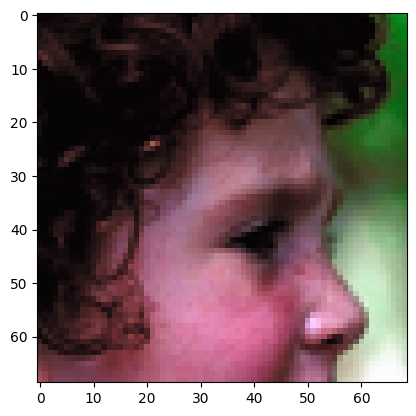

In [29]:
plt.imshow(lower_images[i])

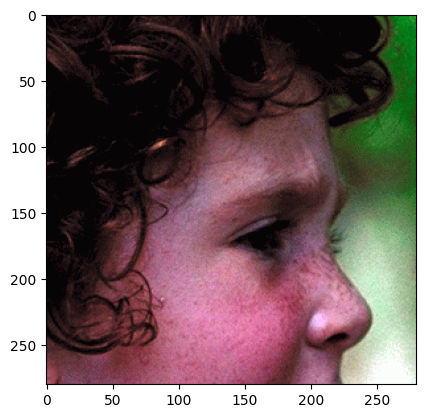

In [30]:
plt.imshow(original_images[i])

In [31]:
trans = get_transform()
test = trans(lower_images[i])
test = test.unsqueeze(0)
test = test.cuda()
test.shape

torch.Size([1, 3, 69, 69])

In [36]:
out = model(test)

out.shape

torch.Size([1, 3, 276, 276])

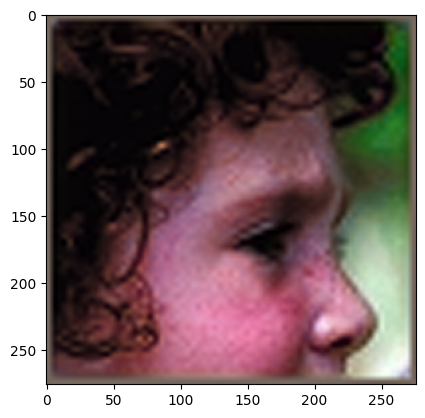

In [37]:
tensor_to_image(out[0])

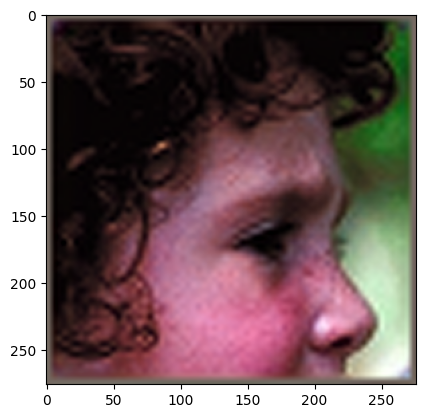

In [34]:
tensor_to_image(out[0])

In [ ]:
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")